In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import imageio

In [14]:
class particle:
    def __init__(self,pos, vel, m):
        self.pos=pos
        self.vel=vel
        self.m=m
    def

        
        

SyntaxError: invalid syntax (Temp/ipykernel_15052/2304867090.py, line 6)

[5.84842877 5.51936131 3.70000713 4.15296408 5.57047295 3.82315593
 3.37335712 5.04328158 4.16680723 5.80509997 6.60793033 5.75417725
 4.22110956 7.19336878 4.66641349 4.5689299  5.35763972 5.35696392
 5.3145533  5.05874274 3.38519629 4.00363446 4.76131382 5.18722935
 4.71103941] 25


In [58]:
########################################
#### Initializing pos and vel lists for simple box simulation
##input: box length, lin density
##output: initpos_x, initpos_y, initvel_x, initvel_y
########################################
def initialize_pos_vel_box(box_l, lin_density):
    pos_x=np.arange(0,box_l,1/lin_density)
    pos_y=np.arange(0,box_l,1/lin_density)
    initpos_x, initpos_y= np.meshgrid(pos_x,pos_y)
    initpos_x=initpos_x.flatten()
    initpos_y=initpos_y.flatten()
    print(initpos_x,initpos_y, len(initpos_x))
    area_density=lin_density**2
    initvel_x=np.zeros(int((box_l**2)*area_density))
    initvel_y=np.zeros(int((box_l**2)*area_density))
    #print(initvel_x,initvel_y, len(initvel_x))
    print("length of vel and pos: {}, {}".format(len(initpos_x),len(initvel_x)))
    return initpos_x, initpos_y, initvel_x, initvel_y
##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  

########################################
#### Initializing pos and vel lists for a simple "galaxy" with fixed # of particles in each spherical bin
##input: list of radii of fixed spherical bins, number of particles in each spherical ring
##output: initpos_x, initpos_y, initvel_x, initvel_y
########################################
def initialize_pos_vel_fixed_ntheta(r, n_theta, sig=1):
    #making set of thetas and radii to combine
    thetas=np.linspace(0,2*np.pi,n_theta,endpoint=False)
    r,thetas=np.meshgrid(r,thetas)
    #combining the radii and thetas
    rx=(r*np.cos(thetas)).flatten()
    ry=(r*np.sin(thetas)).flatten()
    #adding randomness to the positions
    rx=rx+((np.random.randn(1,len(rx))).flatten())/sig
    ry=ry+((np.random.randn(1,len(ry))).flatten())/sig
    #calculating the number of particles "within" each particle that contributes to its ideal circular velocity
    r=np.sqrt(rx**2+ry**2)
    n_within=[np.count_nonzero(r<i) for i in r]
    #calculatingmagnitude of circular velocity 
    v=np.sqrt(G*n*m/r)
    #assigning velocities
    vx=-(v*np.sin(thetas.flatten()))
    vy=(v*np.cos(thetas.flatten()))
    plt.scatter(rx,ry)
    return rx, ry, vx, vy
##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  

########################################
#### Initializing pos and vel lists for a simple "galaxy with fixed linear density,rho_s, in each spherical bin
##input: list of radii of fixed spherical bins, fixed constant linear density of particles in each spherical ring
##output: initpos_x, initpos_y, initvel_x, initvel_y
########################################
def initialize_pos_vel_fixed_rho_s(r, rho_s, sig=1):
    thetas=np.array([])
    rlist=np.array([])
    vlist=np.array([])
    for i in range(len(r)):
        #calculating appropriate number of particles in this ring to maintain rho_s
        n=2*np.pi*r[i]*rho_s
        #getting theta coords for particles in this ring
        theta=np.linspace(0,2*np.pi,int(n),endpoint=False)
        #adding them to the total list of thetas
        thetas=np.concatenate((thetas,theta))
        #adding to the toal list of radii
        rlist=np.concatenate((rlist,r[i]*np.ones(int(n))))
        #going through and giving each partivle a total velcity magnitude
        if i==0:
            vlist=np.concatenate((vlist,np.zeros(int(n))))
        else:
            vlist=np.concatenate((vlist,r[i-1]*np.ones(int(n))))
    #calculating rx,ry
    rx=(rlist*np.cos(thetas))
    ry=(rlist*np.sin(thetas))
    rx=rx+((np.random.randn(1,len(rx))).flatten())/sig
    ry=ry+((np.random.randn(1,len(ry))).flatten())/sig
    r=np.sqrt(rx**2+ry**2)
    #calculating the number of particles "within" each particle that contributes to its ideal circular velocity
    n_within=[np.count_nonzero(r<i) for i in r]
    #calculatingmagnitude of circular velocity 
    v=np.sqrt(G*n*m/r)
    #assigning velocities
    vx=-(v*np.sin(thetas))
    vy=(v*np.cos(thetas))
    plt.scatter(rx,ry)
    return rx, ry,vx,vy
##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  


########################################
## Calculates net forces on each particles and returns list of net forces for particles (list_f)
########################################
def calc_netforce(initpos_x, initpos_y, fl):
    list_fx=np.zeros(len(initpos_x)) 
    list_fy=np.zeros(len(initpos_x))
    list_f=np.zeros(len(initpos_x))
    for i in range(len(initpos_x)):
        r_x=initpos_x-initpos_x[i]
        r_y=initpos_y-initpos_y[i]
        r=np.sqrt(r_x**2+r_y**2)
        #print(r)
        r_x=r_x[r>fl]
        r_y=r_y[r>fl]
        r=r[r>fl] #gets rid of all values that are r_i=0 in the list of r, so we dont have to worry by dividing zero when caluclating the force. 
        #print(len(r), r)
        f_x=G*(m**2)*r_x/(r**(3))
        f_y=G*(m**2)*r_y/(r**(3))
        f=G*(m**2)*r/(abs(r**3))
        #print("f_c: {},  f: {}".format(np.sqrt(f_x**2+f_y**2),np.abs(f)))
        #print("check", np.around(np.abs(f),3)==np.around(np.sqrt(f_x**2+f_y**2),3))
        list_fx[i]=np.sum(f_x)
        list_fy[i]=np.sum(f_y)
        list_f[i]=np.sum(f)
    return(list_fx,list_fy)
##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  

########################################
## Basic Kinematic Functions to be used in function calc_new_pos_vel(...)
########################################
def vel_next(a,vi,dt):
    vf=vi+a*dt
    return vf

def pos_next(a,vi,xi,dt):
    xf=xi+(vi*dt)+(.5*a*dt**2)
    return xf
##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  

########################################
## usinf list_fx and list_fy, calculate the new position and velocity of each particle assumming constant acceleration
########################################
def calc_new_pos_vel(initpos_x, initpos_y, initvel_x, initvel_y, list_fx, list_fy):
    newvel_x=vel_next(list_fx/m,initvel_x,dt)
    newvel_y=vel_next(list_fy/m,initvel_y,dt)
    newpos_x=pos_next(list_fx/m,initvel_x,initpos_x,dt)
    newpos_y=pos_next(list_fy/m,initvel_y,initpos_y,dt)
    return newpos_x, newpos_y, newvel_x, newvel_y
##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  ##  

[0. 2. 4. 6. 8. 0. 2. 4. 6. 8. 0. 2. 4. 6. 8. 0. 2. 4. 6. 8. 0. 2. 4. 6.
 8.] [0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 6. 6. 6. 6. 6. 8. 8. 8. 8.
 8.] 25
length of vel and pos: 25, 25


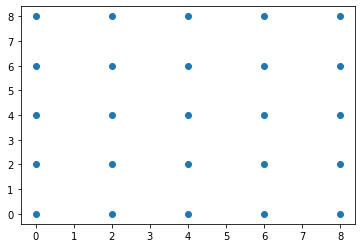

<Figure size 432x288 with 0 Axes>

In [72]:
########################################
## Initiialiszing constants and Lists that will be used
########################################
fl=0.3
G=6.67e-11
G=1                
m=1               #mass of particle in kg
box_l=10          #length of sim box side
lin_density= .5   #linear density (used to calculate area density later)
box_area=box_l**2 #area of initial box
dt=.5  #timestep
timesteps=1000
########################################
## Initiialiszing positions and velcities of particles at t=0
########################################   
initpos_x, initpos_y, initvel_x, initvel_y=initialize_pos_vel_box(box_l, lin_density)
plt.scatter(initpos_x, initpos_y)
plt.show()
for t in range(timesteps):
    list_fx,list_fy=calc_netforce(initpos_x, initpos_y, fl)
    #plt.scatter(initpos_x, initpos_y)
    newpos_x, newpos_y, newvel_x, newvel_y=calc_new_pos_vel(initpos_x, initpos_y, initvel_x, initvel_y, list_fx, list_fy)
    plt.scatter(newpos_x, newpos_y)
    plt.savefig('{}_box.png'.format(t))
    #plt.show()
    plt.clf()
    initpos_x=newpos_x
    initpos_y=newpos_y
    initvel_x=newvel_x
    initvel_y=newvel_y
#plt.xlim(-20,20)
#plt.ylim(-20,20)
filenames=['{}_box.png'.format(t) for t in range(timesteps)]
with imageio.get_writer('gifs/mygif_box.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
plt.show()

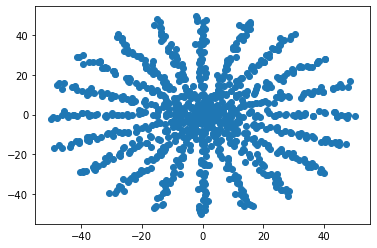

<Figure size 432x288 with 0 Axes>

In [78]:
########################################
## Initiialiszing constants and Lists that will be used
########################################

G=6.67e-11
G=1                
m=1               #mass of particle in kg
box_l=10          #length of sim box side
lin_density= .5   #linear density (used to calculate area density later)
box_area=box_l**2 #area of initial box
dt=.5  #timestep
timesteps=1000
########################################
## Initiialiszing positions and velcities of particles at t=0
########################################   
initpos_x, initpos_y, initvel_x, initvel_y=initialize_pos_vel_fixed_ntheta(np.linspace(1,50,50), 20)
plt.show()
for t in range(timesteps):
    list_fx,list_fy=calc_netforce(initpos_x, initpos_y,fl)
    #plt.scatter(rx, ry)
    newpos_x, newpos_y, newvel_x, newvel_y=calc_new_pos_vel(initpos_x, initpos_y, initvel_x, initvel_y, list_fx, list_fy)
    plt.xlim([-40,60])
    plt.ylim([-40,60])
    plt.scatter(newpos_x, newpos_y)
    plt.savefig('{}_fixed_ntheta.png'.format(t))
    #plt.show()
    plt.clf()
    initpos_x=newpos_x
    initpos_y=newpos_y
    initvel_x=newvel_x
    initvel_y=newvel_y
#plt.xlim(-20,20)
#plt.ylim(-20,20)
plt.show()
filenames=['{}_fixed_ntheta.png'.format(t) for t in range(timesteps)]
with imageio.get_writer('gifs/mygif_fixed_ntheta.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

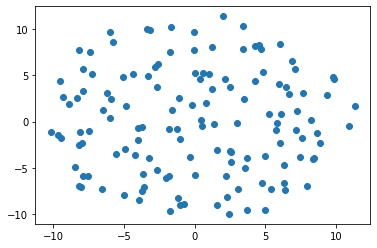

<Figure size 432x288 with 0 Axes>

In [74]:
########################################
## Initiialiszing constants and Lists that will be used
########################################

G=6.67e-11
G=1                
m=1               #mass of particle in kg
box_l=10          #length of sim box side
lin_density= .5   #linear density (used to calculate area density later)
box_area=box_l**2 #area of initial box
dt=.5  #timestep
timesteps=1000
########################################
## Initiialiszing positions and velcities of particles at t=0
########################################   
initpos_x, initpos_y, initvel_x, initvel_y=initialize_pos_vel_fixed_rho_s(np.linspace(1,10,5), 5/2/np.pi)
plt.show()
for t in range(timesteps):
    list_fx,list_fy=calc_netforce(initpos_x, initpos_y,fl)
    #plt.scatter(rx, ry)
    newpos_x, newpos_y, newvel_x, newvel_y=calc_new_pos_vel(initpos_x, initpos_y, initvel_x, initvel_y, list_fx, list_fy)
    plt.xlim([-40,60])
    plt.ylim([-40,60])
    plt.scatter(newpos_x, newpos_y)
    plt.savefig('{}_fixed_rhos.png'.format(t))
    #plt.show()
    plt.clf()
    initpos_x=newpos_x
    initpos_y=newpos_y
    initvel_x=newvel_x
    initvel_y=newvel_y
#plt.xlim(-20,20)
#plt.ylim(-20,20)
plt.show()
filenames=['{}_fixed_rhos.png'.format(t) for t in range(timesteps)]
with imageio.get_writer('gifs/mygif_fixed_rhos.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)